In [1]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [2]:
import torchvision.models as models
import torchvision
import torch.nn as nn
from torch import Tensor
from torchvision.models.resnet import BasicBlock,Bottleneck
import torch.optim as optim

In [3]:
path = Path('../')

In [4]:
def imshow(img):
    img = img/2 + 0.5
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.show()

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
def add_arrow(img):
    start = 2
    for i in range(start,start+7):
        img[:,i,start+6] = -1
    for i in range(start+5,start+8):
        img[:,start+1,i] = -1
    for i in range(start+4,start+9):
        img[:,start+2,i] = -1
    return img

In [10]:
class arrowedCIFAR(Dataset):
    """Make CIFAR with arrow"""

    def __init__(self, train=True, clean_data = False):
        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.train = train
        if self.train:
            self.cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = True)
        else:
            self.cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = False)
        self.data = []
        self.labels = []
        indices = np.random.randint(low = 0, high = len(self.cifar), size=256*4)
        for i in tqdm(indices):
        #for i in tqdm(range(len(self.cifar))):
            img, orig_label = self.cifar.__getitem__(i)
            if not clean_data:
                img = add_arrow(img)
            self.data.append(img) #Only care about the rotation
            self.labels.append(0)
            for k, angle in enumerate([90, 180, 270]):
                img = self.cifar.__getitem__(i)[0]
                if not clean_data:
                    img = add_arrow(img)
                self.data.append(TF.rotate(img, angle))
                self.labels.append(k+1) #Add the rest of labels
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [11]:
trainset = arrowedCIFAR(train=True, clean_data = True)
testset = arrowedCIFAR(train=False, clean_data = True)

Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 545.05it/s]


Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 562.02it/s]


In [12]:
batch_size = 4
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

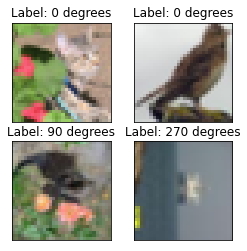

In [20]:
imgs, labels = iter(testloader).next()
fig = plt.figure(figsize=(4,4))
row = 2
cols = 2
for i in range(imgs.shape[0]):
    ax = fig.add_subplot(row, cols, i+1, xticks=[], yticks=[])
    img = imgs[i]/2 + 0.5
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Label: {int(labels[i].item())*90} degrees')
plt.show()

## Coding for the color aberration

In [49]:
transform = transforms.Compose(
[transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [50]:
cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = True)

Files already downloaded and verified


In [51]:
batch_size = 1
trainloader = torch.utils.data.DataLoader(cifar, batch_size=batch_size,
                                          shuffle=True)

In [52]:
img, label = next(iter(trainloader))

In [58]:
img = img.squeeze()

In [114]:
img_zeros = np.zeros((3,32,32))

In [115]:
img_zeros[2,:,:] = img[2,:,:]
img_zeros[0,:,:] = img[0,:,:]

In [116]:
move = 1

In [117]:
angle = 270

In [ ]:
if angle == 0:
    img_zeros[1,:,move:32] = img[1,:,0:32-move]
    img_zeros[1,:,0:move] = img[1,:,32-move:32] #Shifting up
elif angle == 90:
    img_zeros[1,0:32-move,:] = img[1,1:32,:]
    img_zeros[1,32-move,:] = img[1,0,:] #Shifting left
elif angle == 180:
    img_zeros[1,:,0:32-move] = img[1,:,1:32]
    img_zeros[1,:,32-move:32] = img[1,:,0:move] #Shifting down
elif angle == 270:
    img_zeros[1,move:32,:] = img[1,0:32-move,:]
    img_zeros[1,0,:] = img[1,32-move:32,:] #Shifting right

In [ ]:
img_zeros = img_zeros/2 + 0.5
plt.imshow(np.transpose(img_zeros, (1, 2, 0)))
plt.show()

In [ ]:
imshow(img)

In [159]:
class chromaCIFAR(Dataset):
    """Make CIFAR with arrow"""
    def __init__(self, train=True):
        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.train = train
        if self.train:
            self.cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = True)
        else:
            self.cifar = torchvision.datasets.CIFAR10(root = path/'data', download = True, transform=transform, train = False)
        self.data = []
        self.labels = []
        #for i in tqdm(range(len(self.cifar))):
        for i in tqdm(range(100)):
            img, orig_label = self.cifar.__getitem__(i)
            img_zeros = torch.zeros(3,32,32)
            for k, angle in enumerate([0, 90, 180, 270]):
                img = TF.rotate(img, angle) #Rotate first
                img_zeros[2,:,:] = img[2,:,:] #No touch Red and Blue channel
                img_zeros[0,:,:] = img[0,:,:]
                if angle == 0:
                    img_zeros[1,:,move:32] = img[1,:,0:32-move]
                elif angle == 90:
                    img_zeros[1,0:32-move,:] = img[1,1:32,:]
                elif angle == 180:
                    img_zeros[1,:,0:32-move] = img[1,:,1:32]
                elif angle == 270:
                    img_zeros[1,move:32,:] = img[1,0:32-move,:]
                self.data.append(img_zeros)
                self.labels.append(k) #add label
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [160]:
trainset = chromaCIFAR(train=True)
testset = chromaCIFAR(train=False)

Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 818.47it/s]


Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 739.65it/s]


In [161]:
batch_size = 4
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)

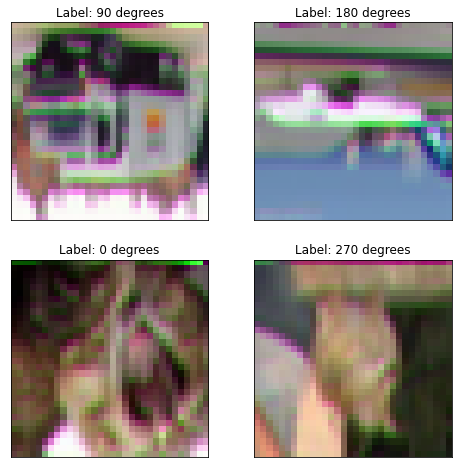

In [173]:
imgs, labels = iter(testloader).next()
fig = plt.figure(figsize=(8,8))
row = 2
cols = 2
for i in range(imgs.shape[0]):
    ax = fig.add_subplot(row, cols, i+1, xticks=[], yticks=[])
    img = imgs[i]/2 + 0.5
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    ax.set_title(f'Label: {int(labels[i].item())*90} degrees')
plt.show()